In [31]:
## Dynamic Influent index computation



In [21]:
os.getcwd ()

'C:\\Users\\user\\Documents\\InfluentIndex'

In [22]:
os.chdir ("C:/Users/user/Documents/InfluentIndex")

In [23]:
os.chdir("C:/Users/user/Documents/InfluentIndex")

In [24]:
file_path = "C:/Users/user/Documents/InfluentIndex/Influent_Index_Data_2023.xlsx"

In [38]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [39]:
# Utility to safe import xgboost and tensorflow (for LSTM)
xgb = None
try:
    import xgboost as xgb_mod
    xgb = xgb_mod
except Exception as e:
    xgb = None

tf = None
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    tf = tf
except Exception as e:
    tf = None
DATA_PATH = Path("C:/Users/user/Documents/InfluentIndex/Influent_Index_Data_2023.xlsx")
# === 1) Load & inspect ===
df = pd.read_excel(DATA_PATH)
# normalize column names
df.columns = [c.strip() for c in df.columns]
print("Columns found:", df.columns.tolist())
display(df.head())


Columns found: ['Date', 'Temp', 'BOD', 'TSS', 'pH', 'PO4', 'Flow']


,Date,Temp,BOD,TSS,pH,PO4,Flow
0,2023-01-01,14.1,NaN,NaN,NaN,NaN,12.607
1,2023-01-02,14.0,NaN,NaN,NaN,NaN,12.020
2,2023-01-03,14.0,371.0,390.0,7.4,7.00,12.851
3,2023-01-04,14.1,NaN,NaN,NaN,NaN,14.918
4,2023-01-05,13.7,347.0,NaN,7.5,6.05,13.261


In [40]:
# Identify candidate 'Date' and 'Flow' columns (case-insensitive)
date_col = None
flow_col = None
for c in df.columns:
    if c.lower() in ("date", "datetime", "time"):
        date_col = c
    if c.lower() in ("flow", "flowrate", "influent", "inflow"):
        flow_col = c
# If not found, try heuristics
if date_col is None:
    # pick first datetime-like column
    for c in df.columns:
        if np.issubdtype(df[c].dtype, np.datetime64):
            date_col = c
            break
if flow_col is None:
    # try to guess numeric column with 'flow' substring
    for c in df.columns:
        if "flow" in c.lower():
            flow_col = c
            break

if date_col is None or flow_col is None:
    raise ValueError("Could not identify Date or Flow columns automatically. Columns: " + ", ".join(df.columns))

print(f"Using Date column: {date_col}, Flow column: {flow_col}")


Using Date column: Date, Flow column: Flow


Data range: 2023-01-01 00:00:00 to 2023-12-31 00:00:00
Total rows: 365 Missing Flow: 0


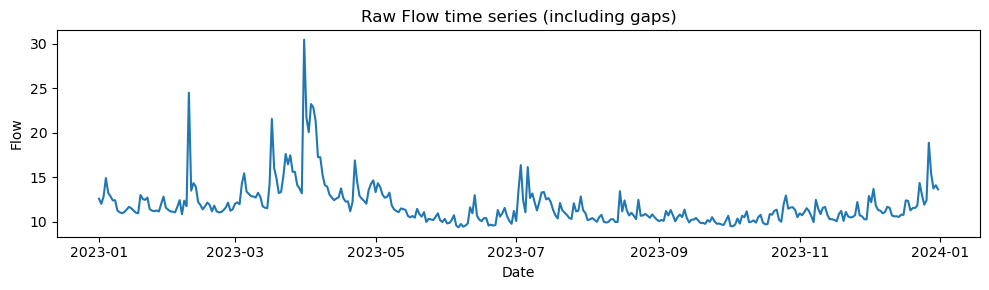

In [41]:
# Parse date and sort
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.sort_values(date_col).reset_index(drop=True)
df = df[[date_col, flow_col]].rename(columns={date_col: "Date", flow_col: "Flow"})
print("Data range:", df['Date'].min(), "to", df['Date'].max())
print("Total rows:", len(df), "Missing Flow:", df['Flow'].isna().sum())

# Display time series
plt.figure(figsize=(10,3))
plt.plot(df['Date'], df['Flow'])
plt.title("Raw Flow time series (including gaps)")
plt.xlabel("Date")
plt.ylabel("Flow")
plt.tight_layout()
plt.show()

In [44]:
# === 2) Missing value imputation options ===
# We will compute three imputations:
#  - Linear time interpolation
#  - Rolling median fill for short gaps + interpolation
#  - Iterative imputer using RandomForest (model-based)

# Set the Date column as the index first
df = df.set_index('Date')  # Add this line to set Date as index

df_interp = df.copy()
df_interp['Flow_linear_interp'] = df_interp['Flow'].interpolate(method='time')

df_roll = df.copy()
# rolling median with window 7 (days) if freq daily; we will try window=3 for robustness
df_roll['Flow_rollmedian'] = df_roll['Flow'].fillna(df_roll['Flow'].rolling(window=7, min_periods=1, center=True).median())
df_roll['Flow_rollmedian'] = df_roll['Flow_rollmedian'].interpolate(method='time')

# Iterative imputer: need numeric index (timestamp -> ordinal)
df_iter = df.copy()
df_iter['ts_ordinal'] = df_iter.index.astype('int64')//10**9  # seconds - modified to use index
imp = IterativeImputer(random_state=0, sample_posterior=False, max_iter=10, estimator=RandomForestRegressor(n_estimators=50, random_state=0))
df_iter_imputed = df_iter.copy()
imputed = imp.fit_transform(df_iter_imputed[['ts_ordinal','Flow']])
df_iter_imputed['Flow_imputed_rf'] = imputed[:,1]

# Show missing counts and quick stats
summary = pd.DataFrame({
    'method': ['raw', 'linear_interp', 'roll_median+interp', 'iterative_rf'],
    'missing_after': [
        df['Flow'].isna().sum(),
        df_interp['Flow_linear_interp'].isna().sum(),
        df_roll['Flow_rollmedian'].isna().sum(),
        df_iter_imputed['Flow_imputed_rf'].isna().sum()
    ]
})
display(summary)


,method,missing_after
0,raw,0
1,linear_interp,0
2,roll_median+interp,0
3,iterative_rf,0


In [45]:
display(df.head())

,Flow
Date,
2023-01-01,12.607
2023-01-02,12.020
2023-01-03,12.851
2023-01-04,14.918
2023-01-05,13.261
